In [1]:
import numpy as np
import random
import imageio
from scipy.fftpack import fftn, ifftn, fftshift
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Implementation of 2 functions
# 1 - Adaptive Denoising
# 2 - Constrained Least Squares Filtering

In [2]:
class third_assignment:

    def __init__(self, filename_deg, type_of_filter, parameter_gamma, parameter_size):
        self.filename_deg = filename_deg
        self.type_of_filter = type_of_filter
        self.parameter_gamma = parameter_gamma
        self.parameter_size = parameter_size

    def __call__(self):

        if not self.check_filter_size():
            raise Exception("Please choose a valid size for the filter.")

        if self.type_of_filter == 1:
            return self.denoising()
        elif self.type_of_filter == 2:
            return self.deblurring()

    def denoising(self):

        # Load mode of denoising
        mode = str(input()).rstrip()

        # Load degraded image
        image = imageio.imread(self.filename_deg)

        padding = int((self.parameter_size - 1)/2)
        reshaped_image = np.pad(image, ((padding, padding),(padding, padding)), mode='constant') # Gotta check if constant is filled with zeros
        filtered_image = []
        center_mask = self.create_mask_center_value(self.parameter_size) # Mask to get central value of matrix
        temp_matrix = np.zeros([self.parameter_size, self.parameter_size])
        center_pixel, centr_l, disp_l = 0,0,0
        percentil3, percentil = 0,0

        if mode == 'average': # Mean and Standard Deviation for centrality and dispersion measurements

            disp_n = self.check_dispersion_n(np.std(image[0:(image.shape[0]//6 - 1), 0:(image.shape[1]//6 - 1)]))
            
            for row in range(reshaped_image.shape[0] - self.parameter_size + 1):
                for column in range(reshaped_image.shape[1] - self.parameter_size + 1):
                    temp_matrix = reshaped_image[row:self.parameter_size+row, column:self.parameter_size+column]
                    centr_l = temp_matrix.mean()
                    disp_l = self.check_dispersion_l(temp_matrix.std(), disp_n)
                    center_pixel = np.sum(temp_matrix*center_mask) # Gets the pixel of the degraded image (center of the matrix)
                    filtered_value = center_pixel - self.parameter_gamma * (disp_n / disp_l) * (center_pixel - centr_l)
                    filtered_image.append(center_pixel - self.parameter_gamma * (disp_n / disp_l) * (center_pixel - centr_l))

        elif mode == 'robust': # Median and Interquatile Range for centrality and dispersion measurements
            
            percentil3, _, percentil1 = self.get_interquatile_median(image[0:(image.shape[0]//6 - 1), 0:(image.shape[1]//6 - 1)]) 
            disp_n = self.check_dispersion_n(percentil3 - percentil1) # Interquatile Range

            for row in range(reshaped_image.shape[0] - self.parameter_size + 1):
                for column in range(reshaped_image.shape[1] - self.parameter_size + 1):
                    temp_matrix = reshaped_image[row:self.parameter_size+row, column:self.parameter_size+column]
                    percentil3, centr_l, percentil1 = self.get_interquatile_median(temp_matrix) # Interquatile Range
                    disp_l = self.check_dispersion_l(percentil3 - percentil1, disp_n)
                    center_pixel = np.sum(temp_matrix*center_mask) # Gets the pixel of the degraded image (center of the matrix)
                    filtered_image.append(center_pixel - self.parameter_gamma * (disp_n / disp_l) * (center_pixel - centr_l))

        filtered_image = np.array(filtered_image).reshape(image.shape[0], image.shape[1])

        filtered_image = self.normalization(filtered_image, image)

        return filtered_image

    def deblurring(self):

        # Load sigma for gaussian filter
        sigma = float(input())
        sigma = self.check_sigma(sigma)

        # Load degraded image
        image = imageio.imread(self.filename_deg)

        # Laplacian Operator
        laplacian_op = np.array([[0, -1, 0],
                                 [-1, 4, -1],
                                 [0, -1, 0]])

        # Padding Operator
        pad = int(image.shape[0]//2 - laplacian_op.shape[0]//2)
        px_pad = np.pad(laplacian_op, (pad,pad-1), 'constant', constant_values=(0))

        # Degradation Function
        h_deg = self.gaussian_filter(self.parameter_size,sigma)

        # Padding Degradation Matrix
        pad = int(image.shape[0]//2 - h_deg.shape[0]//2)
        H_pad = np.pad(h_deg, (pad,pad-1), 'constant', constant_values=(0))

        # Computing the Fourier transforms
        G_deg = fftn(image)
        H_U = fftn(H_pad)
        P_U = fftn(px_pad)

        # Calculating the CLS function
        filtered_image = (H_U.conjugate() / (np.abs(H_U)**2 + self.parameter_gamma * np.abs(P_U) ** 2)) * G_deg

        # Passing it for the spatial domain
        filtered_image = fftshift(ifftn(filtered_image).real)

        # Normalization based on input data
        filtered_image = self.normalization(filtered_image, image)

        return filtered_image

    def gaussian_filter(self, k=3, sigma=1.0): # We assume the degradation function for the deblurring is a gaussian filter
        arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
        x, y = np.meshgrid(arx, arx)
        filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
        return filt / np.sum(filt)

    def check_filter_size(self):
        if self.parameter_size in [3,5,7,9,11]:
            return True
        return False

    def check_sigma(self, sigma):
        if sigma > 0:
            return sigma
        raise Exception("Please choose a valid sigma.")

    def check_dispersion_n(self, value):
        if value == 0:
            return 1
        return value

    def check_dispersion_l(self, value, disp_n):
        if value == 0:
            return disp_n
        return value

    def create_mask_center_value(self, size):
        center = size//2
        mask = np.zeros([size, size])
        mask[center, center] = 1
        return mask

    def get_interquatile_median(self, matrix):
        percentiles = np.percentile(matrix, [75, 50, 25])
        return percentiles

    def normalization(self, image, reference):
        min_ = np.min(image)
        max_ = np.max(image)
        quantized_image = np.max(reference)*(((image - min_)/(max_ - min_)))
        return quantized_image

In [3]:
# Function that calculates how far the images are from the testing set    
def RMSE(image1, image2):
    image1 = image1.astype(float)
    image2 = image2.astype(float)
    return np.float(np.sqrt(((image1 - image2)**2).mean()))

# A simple function for visualization
def comparing_images(image1, image2):
    _ = plt.figure(figsize=(5,5))
    _ = plt.subplot(1,2,1)
    _ = plt.imshow(image1, cmap='gray')
    _ = plt.subplot(1,2,2)
    _ = plt.imshow(image2, cmap='gray')
    plt.show()

In [4]:
def denoising(image, type_of_filter, parameter_size, parameter_gamma):
    
    padding = int((parameter_size - 1)/2)
    reshaped_image = np.pad(image, ((padding, padding),(padding, padding)), mode='constant') # Gotta check if constant or symmetric
    filtered_image = []
    center_mask = create_mask_center_value(parameter_size)
    temp_matrix = np.zeros([parameter_size, parameter_size])
    center_pixel, centr_l, disp_l = 0,0,0
    
    if type_of_filter == 1: # Average mode
    
        disp_n = check_dispersion_n(np.std(reshaped_image[0:(reshaped_image.shape[0]//6 - 1), 0:(reshaped_image.shape[1]//6 - 1)]))

        for row in range(reshaped_image.shape[0] - parameter_size + 1):
            for column in range(reshaped_image.shape[1] - parameter_size + 1):
                temp_matrix = reshaped_image[row:parameter_size+row, column:parameter_size+column]
                centr_l = temp_matrix.mean()
                disp_l = check_dispersion_l(temp_matrix.std(), disp_n)
                center_pixel = np.sum(temp_matrix*center_mask)
                filtered_image.append(center_pixel - parameter_gamma * (disp_n / disp_l) * (center_pixel - centr_l))
    
    elif type_of_filter == 2: # Robust mode
        
        disp_n = check_dispersion_n(get_interquatile_range(reshaped_image[0:(reshaped_image.shape[0]//6 - 1), 0:(reshaped_image.shape[1]//6 - 1)])) # Interquatile Range

        for row in range(reshaped_image.shape[0] - parameter_size + 1):
            for column in range(reshaped_image.shape[1] - parameter_size + 1):
                temp_matrix = reshaped_image[row:parameter_size+row, column:parameter_size+column]
                centr_l = np.median(temp_matrix)
                disp_l = check_dispersion_l(get_interquatile_range(temp_matrix), disp_n) # Interquatile Range
                center_pixel = np.sum(temp_matrix*center_mask)
                filtered_image.append(center_pixel - parameter_gamma * (disp_n / disp_l) * (center_pixel - centr_l))

    filtered_image = np.array(filtered_image).reshape(image.shape[0], image.shape[1])
        
    filtered_image = normalization(filtered_image, image)
    
    return filtered_image    

def gaussian_noise(size, mean=0, std=0.01):
    '''
    Generates a matrix with Gaussian noise in the range [0-255] to be added to an image
    
    :param size: tuple defining the size of the noise matrix 
    :param mean: mean of the Gaussian distribution
    :param std: standard deviation of the Gaussian distribution, default 0.01
    :return matrix with Gaussian noise to be added to image
    '''
    noise = np.multiply(np.random.normal(mean, std, size), 255)
    
    return noise

RMSE degraded image 1
20.47064614732791
RMSE degraded image 2
22.73375915129284


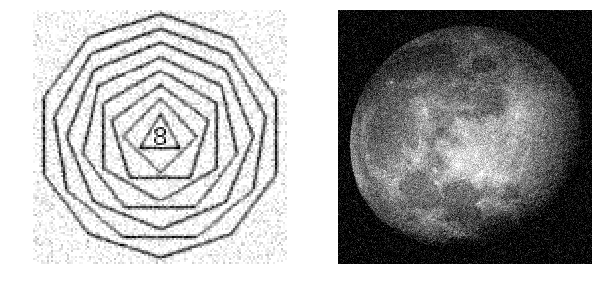

In [5]:
# Images with Gaussian Noise

img1 = imageio.imread("polygons128.png")
img2 = imageio.imread("moon.jpg")

gau_noise = gaussian_noise(img1.shape, mean=0, std=0.1)
img1_deg = np.clip(img1.astype(int)+gau_noise, 0, 255)
#imageio.imwrite('poly_noised.png', img1_deg.astype(np.uint8)) 

gau_noise = gaussian_noise(img2.shape, mean=0, std=0.1)
img2_deg = np.clip(img2.astype(int)+gau_noise, 0, 255)
#imageio.imwrite('moon_noised.png', img2_deg.astype(np.uint8))

plt.figure(figsize=(10,10))
plt.subplot(121) 
plt.imshow(img1_deg, cmap="gray")
plt.axis('off')
plt.subplot(122)
plt.imshow(img2_deg, cmap="gray")
plt.axis('off')

print("RMSE degraded image 1")
print(RMSE(img1, img1_deg))
#print(rmse(img1, img1_deg))

print("RMSE degraded image 2")
print(RMSE(img2, img2_deg))
#print(rmse(img2, img2_deg))

#print(get_interquatile_range(img1[0:(img1.shape[0]//6 - 1), 0:(img1.shape[1]//6 - 1)]))
#print(get_interquatile_range(img2[0:(img2.shape[0]//6 - 1), 0:(img2.shape[1]//6 - 1)]))
#print(get_interquatile_range(img1_deg[0:(img1_deg.shape[0]//6 - 1), 0:(img1_deg.shape[1]//6 - 1)]))
#print(get_interquatile_range(img2_deg[0:(img2_deg.shape[0]//6 - 1), 0:(img2_deg.shape[1]//6 - 1)]))

 robust
 robust


RMSE denoised image 1 - Average Mode
18.534522306141348
RMSE denoised image 1 - Robust Mode
17.759634031906934


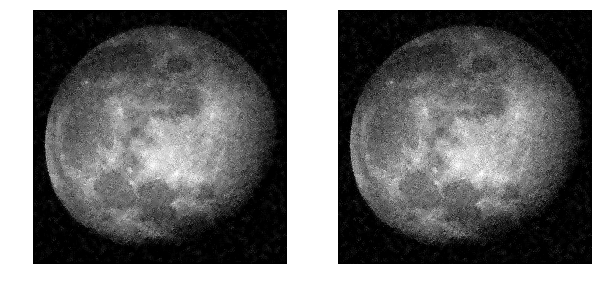

In [7]:
#img1_deg = imageio.imread('moon_noised.png')

img1_denoised_avg = third_assignment('moon_noised.png', 1, 0.95, 5)()
img1_denoised_rob = third_assignment('moon_noised.png', 1, 0.8, 5)()
    
plt.figure(figsize=(10,10))                                                    
plt.subplot(121) 
plt.imshow(img1_denoised_avg, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.imshow(img1_denoised_rob, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

print("RMSE denoised image 1 - Average Mode")
print(RMSE(img2, img1_denoised_avg))

print("RMSE denoised image 1 - Robust Mode")
print(RMSE(img2, img1_denoised_rob))

In [ ]:
def fft_imagefilter(g, size):
    ''' A function to filter an image g with the filter w
    '''
    # creating a [size,size] mean filter
    w = np.ones([size,size])/float(size*size)

    # padding the filter so that it has the same size of the image
    pad1 = (g.shape[0]//2)-w.shape[0]//2
    wp = np.pad(w, (pad1,pad1-1), "constant",  constant_values=0)
    
    # computing the Fourier transforms
    W = fftn(wp)
    G = fftn(g)
    R = np.multiply(W,G)
    
    r = np.real(fftshift(ifftn(R)))
    return r

r_mean_1 = fft_imagefilter(img1_deg, 3)
r_mean_2 = fft_imagefilter(img2_deg, 3)

plt.figure(figsize=(10,10))
plt.subplot(121) 
plt.imshow(r_mean_1, cmap="gray")
plt.axis('off')
plt.subplot(122)
plt.imshow(r_mean_2, cmap="gray")
plt.axis('off')

print("RMSE denoised image 1")
print(RMSE(img1, r_mean_1))

print("RMSE denoised image 2")
print(RMSE(img2, r_mean_2))

In [9]:
def gaussian_bluring(image, k=3, sigma=1.0):
    
    ''' Gaussian filter
    :param k: defines the lateral size of the kernel/filter, default 5
    :param sigma: standard deviation (dispersion) of the Gaussian distribution
    :return matrix with a filter [k x k] to be used in convolution operations
    '''
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
    filt = filt / np.sum(filt)
    
    # computing the number of padding on one side
    a = int(image.shape[0]//2 - filt.shape[0]//2)
    h_pad = np.pad(filt, (a,a-1), 'constant', constant_values=(0))
    
    #_ = plt.imshow(h_pad, cmap="gray")
    
    # computing the Fourier transforms
    F = fftn(image)
    H = fftn(h_pad)

    #plt.subplot(121)
    #plt.imshow(np.log(np.abs(F)+1), cmap="gray")
    #plt.subplot(122)
    #plt.imshow(np.log(np.abs(H)+1), cmap="gray")

    # convolution
    G = np.multiply(F,H)

    # Inverse Transform
    # - we have to perform FFT shift before reconstructing the image in the space domain
    g = fftshift(ifftn(G).real)
    
    return g

def gaussian_filter(k=3, sigma=1.0): # We assume the degradation function is a gaussian filter
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))    
    return filt / np.sum(filt)

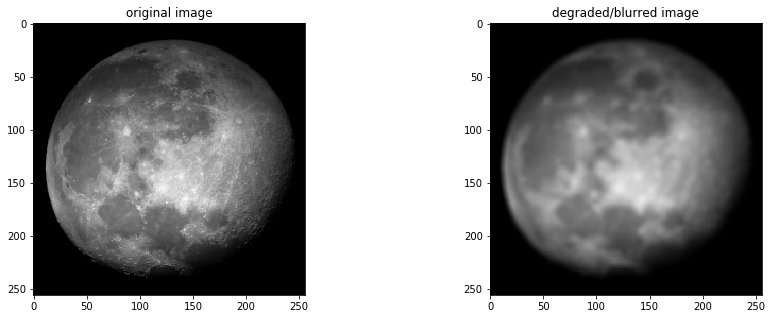

RMSE Original and Blurred Image 2
7.2137047777888545


In [10]:
img2_blurred = gaussian_bluring(img2, k=7, sigma=5)
imageio.imwrite('moon_blurred.png', img2_blurred.astype(np.uint8)) # K=11, Sigma=10
img2_blurred = imageio.imread('moon_blurred.png')

#print(img2_blurred[100:150, 100:150].astype(np.uint8))
#print(img2_blurred_1[100:150, 100:150])
#print((img2_blurred.astype(np.uint8) == img2_blurred_1).all())

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255); plt.title("original image")
plt.subplot(122)
plt.imshow(img2_blurred, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.show()

print("RMSE Original and Blurred Image 2")
print(RMSE(img2, img2_blurred))

 10


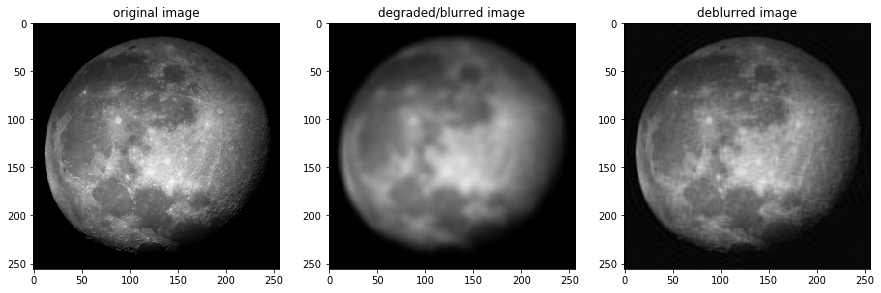

RMSE Original and Blurred Image 2
8.238579542028072
RMSE Original and Deblurred Image 2
8.302560118426474


In [13]:
img2_blurred = gaussian_bluring(img2, k=9, sigma=10)
#imageio.imwrite('moon_blurred.png', img2_blurred.astype(np.uint8)) # K=11, Sigma=10

img2_deblurred = third_assignment('moon_blurred.png', 2, 0.0005, 9)()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255); plt.title("original image")
plt.subplot(132)
plt.imshow(img2_blurred, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(133)
plt.imshow(img2_deblurred, cmap="gray", vmin=0, vmax=255); plt.title("deblurred image")
plt.show()

print("RMSE Original and Blurred Image 2")
print(RMSE(img2, img2_blurred))

print("RMSE Original and Deblurred Image 2")
print(RMSE(img2, img2_deblurred))